In [1]:
import os
import math
import random
import statistics

import numpy as np

import torch
from torch import nn
from torch import Tensor

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

from sklearn import datasets as sk_datasets

In [2]:
def seed_everython(seed=3407):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everython(3407)

In [146]:
def extract_into_tensor(tensor, shape):
    num_expand_dims = len(shape) - 1
    return tensor.view([-1] + [1 for _ in range(num_expand_dims)])


def scatter(tensor):
    plt.scatter(tensor[:, 0], tensor[:, 1])
    

def plot_trajectory(trajectory, indices: None | list = None):
    if indices is not None:
        trajectory = [trajectory[i] for i in indices]

    f, a  = plt.subplots(1, len(trajectory), figsize=(4 * len(trajectory), 4))
    for i, sample in enumerate(trajectory):
        a[i].set_title(f'step: {i}')
        a[i].scatter(sample[:, 0], sample[:, 1])
        a[i].set_xlim(-1.5, 1.5)
        a[i].set_ylim(-1.5, 1.5)
    plt.show()
    return f

# Data

In [4]:
class DatasetRegistry:
    def __init__(self):
        self.dataset_generators = {}

    def add(self, func=None, name=None):
        def _decorator(func):
            self.dataset_generators[name or func.__name__] = func
            return func
        
        return _decorator if func is None else _decorator(func) 
    
    def __getitem__(self, name):
        return self.dataset_generators[name]
    
    @property
    def available_datasets(self):
        return list(self.dataset_generators)


registry = DatasetRegistry()


def rotate_mean(mean, angle=torch.pi / 3):
    rotate = torch.as_tensor([
        [math.cos(angle), -math.sin(angle)],
        [math.sin(angle), math.cos(angle)],
    ])
    return mean @ rotate


@registry.add(name='mix_of_gaussians')
def mix_of_gaussians(batch_size, means=None, sigmas=None):
    if means is None and sigmas is None:
        return torch.randn(batch_size, 2)
    
    if means is None:
        assert batch_size % sigmas.size(0) == 0, 'batch size should be divisible by the number of modes'
        # sigmas = torch.tensor(sigmas)
        z = torch.randn(batch_size // sigmas.size(0), sigmas.size(0), 2)
        return (z * sigmas).view(-1, 2)

    if sigmas is None:
        assert batch_size % means.size(0) == 0, 'batch size should be divisible by the number of modes'
        # means = torch.tensor(means)
        z = torch.randn(batch_size // means.size(0), means.size(0), 2)
        return (z + means).view(-1, 2)

    assert batch_size % sigmas.size(0) == 0, 'batch size should be divisible by the number of modes'
    # means = torch.tensor(means)
    # sigmas = torch.tensor(sigmas)
    z = torch.randn(batch_size // means.size(0), means.size(0), 2)

    return (z * sigmas + means).view(-1, 2)


@registry.add(name='two_moons')
def two_moons(batch_size, shift=None, noise=None):
    samples, _ = sk_datasets.make_moons(batch_size, noise=(noise or 0))
    samples[:, 0] = samples[:, 0] * 2 / 3 - 1 / 3
    samples[:, 1] = samples[:, 1] * 4 / 3 - 1 / 3
    samples = torch.from_numpy(samples) + (shift if shift is not None else 0)
    return samples.float()


@registry.add(name='two_circles')
def two_circles(batch_size, shift=None, noise=None):
    assert noise < 0.04, 'very high noise'
    samples, _ = sk_datasets.make_circles(batch_size, noise=(noise or 0))
    samples = torch.from_numpy(samples) + (shift if shift is not None else 0)
    return samples.float()


@registry.add(name='s_curve')
def s_curve(batch_size, shift=None, noise=None):
    samples, *_ = sk_datasets.make_s_curve(batch_size, noise=(noise or 0))
    samples[:, 2] /= 2 
    samples = torch.from_numpy(samples[:, [0, 2]]) + (shift if shift is not None else 0)
    return samples.float()


@registry.add(name='swiss_roll')
def swiss_roll(batch_size, shift=None, noise=None):
    samples, _ = sk_datasets.make_swiss_roll(batch_size, noise=(noise or 0))
    samples = samples * 8 / 7  - 1 / 7
    samples = torch.from_numpy(samples[:, [0, 2]]) / 15 + (shift if shift is not None else 0)
    return samples.float()


@registry.add(name='checkboard')
def checkboard(batch_size, shift=None):
    samples = torch.rand(batch_size * 3, 2) * 2 + torch.tensor([[-1, -1]])

    x_mask = (samples[:, 0] > 0.5) + (0 > samples[:, 0]) * (samples[:, 0] > -0.5)
    y_mask = (samples[:, 1] > 0.5) + (0 > samples[:, 1]) * (samples[:, 1] > -0.5)

    mask = x_mask ^ y_mask
    samples = samples[mask][:batch_size] + (shift if shift is not None else 0)
    return samples.float()

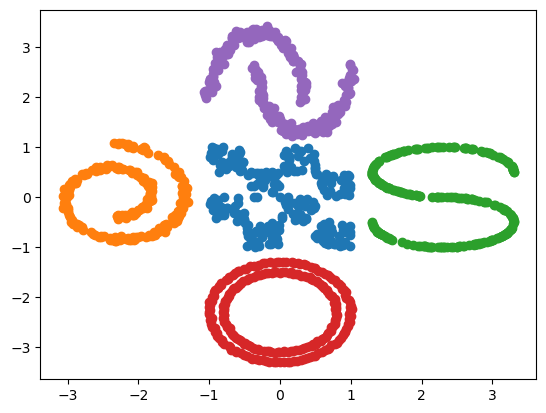

In [5]:
scatter(checkboard(256))
scatter(swiss_roll(256, noise=0.3, shift=torch.tensor([[-2.3, 0]])))
scatter(s_curve(256, noise=0.0, shift=torch.tensor([[2.3, 0]])))
scatter(two_circles(256, noise=0.01, shift=torch.tensor([[0, -2.3]])))
scatter(two_moons(256, noise=0.05, shift=torch.tensor([[0, 2.3]])))

plt.show()

In [6]:
class DatasetSampler:
    def __init__(self, p_0: str, p_1: str, p_0_args: list | None = None, p_1_args: list | None = None):
        datasets = set(registry.available_datasets)
        
        assert p_0 in datasets, f'{p_0} is not one of {datasets}'
        assert p_1 in datasets, f'{p_1} is not one of {datasets}'
        
        self.p_0 = p_0
        self.p_1 = p_1

        self.p_0_args = p_0_args
        self.p_1_args = p_1_args
        
    def _iterator(self, batch_size):
        
        x_0 = registry[self.p_0](batch_size, *self.p_0_args)
        x_1 = registry[self.p_1](batch_size, *self.p_1_args)
        yield x_0, x_1

    def sample(self, batch_size):
        return next(self._iterator(batch_size))

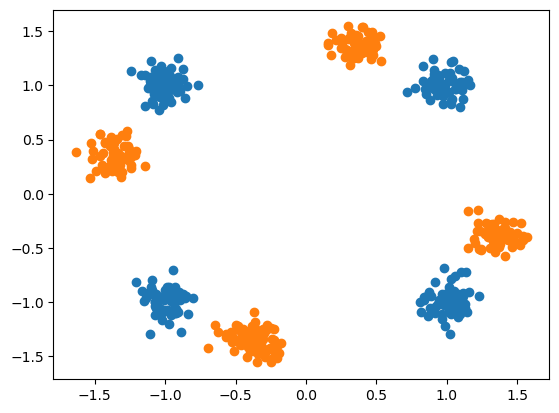

In [7]:
mean = torch.tensor([[-1, 1], [1, 1], [1, -1], [-1, -1]]) * 1.0
sigmas = torch.ones_like(mean) * 0.1

sampler = DatasetSampler(
    p_0='mix_of_gaussians', p_0_args=[mean, sigmas],
    p_1='mix_of_gaussians', p_1_args=[rotate_mean(mean), sigmas],
)

x_0, x_1 = sampler.sample(256)

scatter(x_0)
scatter(x_1)

# Model

In [8]:
def time_fourier_proj(time, embed_dim, max_dim=1e4):
    max_log_dim = math.log(max_dim) / (embed_dim // 2 - 1)
    embeddings = time[:, None] * torch.exp(torch.arange(embed_dim // 2) * (- max_log_dim))[None, :]
    return torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)


def time_proj(time, embed_dim):
    W = torch.randn(1, embed_dim // 2) * 2 * torch.pi
    embeddings = time[:, None] * W
    return torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)

t = torch.rand(32)

In [9]:
class SimpleNet(nn.Module):
    def __init__(
            self, 
            t_emb_size: int, 
            x_emb_size: int, 
            predict_sigma: bool = False
        ):
        super().__init__()
        self.t_emb_size = t_emb_size
        self.x_emb_size = x_emb_size
        self.use_t = t_emb_size > 0
        self.predict_sigma = predict_sigma

        self.x_embed = nn.Sequential(
            nn.Linear(2, x_emb_size),
            nn.ReLU(),
            nn.Linear(x_emb_size, x_emb_size)
        )
        
        combined_hidden_size = x_emb_size
        
        if self.use_t:
            self.t_embed = nn.Sequential(
                nn.Linear(t_emb_size, x_emb_size),
                nn.ReLU(),
                nn.Linear(x_emb_size, x_emb_size)
            )
            combined_hidden_size += x_emb_size


        self.out_layer = nn.Sequential(
            nn.Linear(combined_hidden_size, x_emb_size),
            nn.ReLU(),
            nn.Linear(x_emb_size, 2)
        )

        if self.predict_sigma:
            self.sigma = nn.Sequential(
                nn.Linear(combined_hidden_size, x_emb_size),
                nn.ReLU(),
                nn.Linear(x_emb_size, 2)
            )

    def forward(self, x, t):
        embeddings = self.x_embed(x)

        if self.use_t:
            t_embed = time_fourier_proj(t, self.t_emb_size)
            t_embed = self.t_embed(t_embed)
            embeddings = torch.cat([embeddings, t_embed], dim=-1)
        
        out = self.out_layer(embeddings)
        
        if self.predict_sigma:
            log_sigma = self.sigma(embeddings)
            sigma = nn.functional.softplus(log_sigma)
            return out, sigma

        return out
    
    
t = torch.rand(32)
x = torch.randn(32, 2)

f = SimpleNet(64, 64)
f(x, t).shape

torch.Size([32, 2])

# DDPM

In [167]:
def linear_schedule(n_steps):
    scale = 1000 / n_steps
    start, end = scale * 0.0001, scale * 0.02
    return torch.linspace(start, end, n_steps)


class DDPM:
    def __init__(self, schedule, n_steps):
        self.n_steps = n_steps
        
        self.betas = schedule
        self.alphas = 1 - self.betas
        
        self.cumprod_alphas = self.alphas.cumprod(0)
        self.prev_cumprod_alphas = torch.cat([torch.ones(1), self.cumprod_alphas[:-1]])
        
        self._1m_cumprod_alphas = 1 - self.cumprod_alphas
        self._1m_prev_cumprod_alphas = 1 - self.prev_cumprod_alphas
        
        self.post_x_0_coeff = self.prev_cumprod_alphas.sqrt() * self.betas / (self._1m_cumprod_alphas)
        self.post_x_t_coeff = self.alphas.sqrt() * (self._1m_prev_cumprod_alphas) / (self._1m_cumprod_alphas)
        self.post_var = (self._1m_prev_cumprod_alphas) * self.betas / (self._1m_cumprod_alphas)
    
    def sample_x_t_from_x_0(self, x_0, t, noise=None):
        mean_coeff = extract_into_tensor(self.cumprod_alphas[t].sqrt(), x_0.shape)
        std = extract_into_tensor(self._1m_cumprod_alphas[t].sqrt(), x_0.shape)
        
        if noise is None:
            noise = torch.randn_like(x_0)
            
        return mean_coeff * x_0 + std * noise
    
    def predict_x_0_from_noise(self, x_t, t, pred_eps):
        std = extract_into_tensor(self._1m_cumprod_alphas[t].sqrt(), x_t.shape)
        mean_coeff = extract_into_tensor(self.cumprod_alphas[t].sqrt(), x_t.shape)
        
        x_0_pred = (x_t - std * pred_eps) / mean_coeff
        return x_0_pred.float()
        
    def sample_x_t_m1_from_x_t_and_x_0(self, x_t, t, pred_eps):
        x_0_coeff = extract_into_tensor(self.post_x_0_coeff[t], x_t.shape)
        x_t_coeff = extract_into_tensor(self.post_x_t_coeff[t], x_t.shape)
        var = extract_into_tensor(self.post_var[t], x_t.shape)
        
        x_0_pred = self.predict_x_0_from_noise(x_t, t, pred_eps)
        mean = x_0_coeff * x_0_pred + x_t_coeff * x_t
        
        non_zero_mask = extract_into_tensor((t != 0), x_t.shape)
        return {
            'sample': mean + non_zero_mask * torch.randn_like(x_t) * var.sqrt(),
            'mean': mean,
            'std': var.sqrt()
        }
        
    def sample_x_t_m1_simpler(self, x_t, t, pred_eps):
        alpha_t = extract_into_tensor(self.alphas[t], x_t.shape)
        sqrt_1m_cumprod_alpha_t = extract_into_tensor(self._1m_cumprod_alphas[t], x_t.shape).sqrt()
        beta_t = extract_into_tensor(self.betas[t], x_t.shape)
        
        mean = 1 / alpha_t * (x_t - pred_eps * beta_t / sqrt_1m_cumprod_alpha_t)
        sigma = extract_into_tensor(self.post_var[t].sqrt(), x_t.shape)
        
        non_zero_mask = extract_into_tensor((t != 0), x_t.shape)
        return {
            'sample': mean + non_zero_mask * torch.randn_like(x_t) * sigma,
            'mean': mean,
            'std': sigma
        }
        
    def ansesterial_sampling_step(self, x_t, t, model):
        sqrt_1m_cumprod_alpha_t = extract_into_tensor(self._1m_cumprod_alphas[t], x_t.shape).sqrt()
        score = - model(x_t, t) / (sqrt_1m_cumprod_alpha_t + 1e-6)
        
        beta_t = extract_into_tensor(self.betas[t], x_t.shape)
        x_prev = 1 / (1 - beta_t) * (x_t + beta_t * score) + beta_t.sqrt() * torch.randn_like(x_t)
        
        return {
            'sample': x_prev
        }
        
    def make_ddim_step(self, model, x_t, t, ddim_sigma):
        pred_eps = model(x_t, t)
        x_0_pred = self.predict_x_0_from_noise(x_t, t, pred_eps)
        
        mean_coeff = extract_into_tensor(self.prev_cumprod_alphas[t].sqrt(), x_0.shape)
        std = extract_into_tensor((self._1m_prev_cumprod_alphas[t] - ddim_sigma**2).sqrt(), x_0.shape)
        
        x_t_prev = mean_coeff * x_0_pred + std * pred_eps + torch.randn_like(x_t) * ddim_sigma
        return x_t_prev
    
    def make_ddpm_step(self, model, x_t, t):
        pred_eps = model(x_t, t)
        x_t_prev = self.sample_x_t_m1_from_x_t_and_x_0(x_t, t, pred_eps)['sample']
        return x_t_prev
    
    def make_simple_ddpm_step(self, model, x_t, t):
        pred_eps = model(x_t, t)
        x_t_prev = self.sample_x_t_m1_simpler(x_t, t, pred_eps)['sample']
        return x_t_prev
        
    @torch.no_grad()
    def sample(self, model, shape, 
               sample_with: str = 'ddpm',
               ddim_sigma: float = 0.0
               ):
        x_t = torch.randn(shape)
        for t in range(self.n_steps -1, -1, -1):
            t = torch.ones(x_t.size(0), dtype=torch.long) * t
            if sample_with == 'ddpm':
                x_t = self.make_ddpm_step(model, x_t, t)
            elif sample_with == 'ddim':
                x_t = self.make_ddim_step(model, x_t, t, ddim_sigma)
            elif sample_with == 'simple_ddpm':
                x_t = self.make_simple_ddpm_step(model, x_t, t)
            elif sample_with == 'ansesterial':
                x_t = self.ansesterial_sampling_step(x_t, t, model)['sample']    
            else:
                raise ValueError(f"Unknown sampling method {sample_with}")
            
        return x_t

    def train_loss(self, model, x_0, t):
        noise = torch.randn_like(x_0)
        x_t = self.sample_x_t_from_x_0(x_0, t, noise)
        loss = nn.functional.mse_loss(model(x_t, t), noise)
        return loss

In [168]:
x_0, x_1 = next(sample_batch(256, spread=3.5, sigma=0.2))

trajectory = [x_0]
for t in range(19, ddpm.n_steps, ddpm.n_steps // 10):
    # print(t)
    x_t = ddpm.sample_x_t_from_x_0(x_0, t)
    trajectory.append(x_t)

plot_trajectory(trajectory)

NameError: name 'ddpm' is not defined

In [ ]:
model = SimpleNet(64, 64)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
ddpm = DDPM(linear_schedule(100), 100)

loss_history = []
for i in trange(5000):
    x_0, _ = next(sample_batch(256, spread=3.5, sigma=0.2))
    t = torch.randint(0, ddpm.n_steps, (x_0.size(0),))
    loss = ddpm.train_loss(model, x_0, t)
    
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    
    loss_history.append(loss.item())    

  0%|          | 0/5000 [00:00<?, ?it/s]

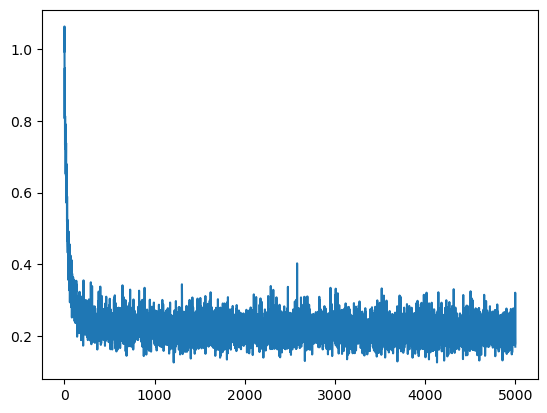

In [ ]:
plt.plot(loss_history)
plt.show()

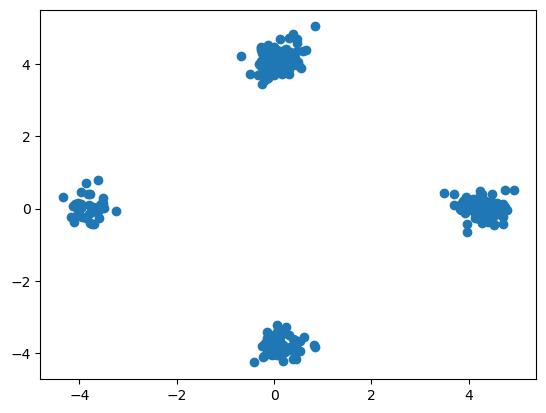

In [ ]:
ddpm = DDPM(linear_schedule(100), 100)
x_t = ddpm.sample(model, (256, 2), sample_with='ansesterial')

scatter(x_t)

In [ ]:
# class SLMD:
    # def __init__(self, ):
    #     pass
    
    

# VP SDE

In [ ]:
class VPSDE:
    t_max = 1.0
    
    def __init__(self, beta_min, beta_max, n_steps):
        self.beta_min = beta_min #* 1000 / n_steps
        self.beta_max = beta_max #* 1000 / n_steps
        self.n_steps = n_steps

    def get_beta_t(self, t):
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def get_mean_coeff_and_std(self, t):
        log_coeff = - 0.25 * t**2 * (self.beta_max - self.beta_min) - 0.5 * t * self.beta_min
        mean = torch.exp(log_coeff)
        std = torch.sqrt(1 - torch.exp(2.0 * log_coeff))
        return mean, std

    def sample_x_t_from_x_0(self, x_0, t, noise: Tensor | None = None):
        if noise is None:
            noise = torch.randn_like(x_0)
        
        mean, std = self.get_mean_coeff_and_std(t)
        return extract_into_tensor(mean, x_0.shape) * x_0 + noise * extract_into_tensor(std, x_0.shape)

    def get_sde_params(self, x_t, t):
        '''
            Compute coefficient for SDE:
            dx_t = f_t * dt + g_t * dW_t
        '''
        beta_t = extract_into_tensor(self.get_beta_t(t), x_t.shape)
        drift = - 0.5 * beta_t * x_t
        
        return drift, beta_t.sqrt()
    
    def get_reverse_sde_params(self, score, x_t, t, ode_flow: bool = False):
        drift, diff = self.get_sde_params(x_t, t)
        rev_drift = drift - diff**2 * score * (0.5 if ode_flow else 1.0)
        
        return rev_drift, diff

    def compute_loss(self, model, x_0, t, learn_score: bool = True):
        noise = torch.randn_like(x_0)
        
        time = torch.maximum(t, torch.as_tensor(1e-3))
        x_t = self.sample_x_t_from_x_0(x_0, time, noise)
        
        if learn_score:
            mean_coeff, std = self.get_mean_coeff_and_std(time)
            mean_coeff = extract_into_tensor(mean_coeff, x_0.shape)
            std = extract_into_tensor(std, x_0.shape)
            
            score = - (x_t - mean_coeff * x_0) / std**2
            loss = nn.functional.mse_loss(model(x_t, t), score)
        else:
            loss = nn.functional.mse_loss(model(x_t, t), noise)

        return loss

    def score_from_noise(self, model, x_t, t):
        eps_pred = model(x_t, t)
        _, std = self.get_mean_coeff_and_std(t)
        return - eps_pred / extract_into_tensor(std, eps_pred.shape)

    def make_fwd_step(self, x_t, t, dt: float | None = None):
        '''
            Noise for forward process.
        '''
        z = torch.randn_like(x_t)
        drift, sigma = self.get_sde_params(x_t, t)
        if dt is None:
            dt = self.t_max / self.n_steps
        
        return drift * dt + sigma * math.sqrt(dt) * z

    @torch.no_grad
    def make_bwd_step(self, score, x_t, t, dt: float | None = None, ode_flow: bool = False):
        '''
            Denoising backward process.
        '''
        z = torch.randn_like(x_t)
        drift, diff = self.get_reverse_sde_params(score, x_t, t, ode_flow)
        if dt is None:
            dt = - self.t_max / self.n_steps
        
        dx = drift * dt
        if not ode_flow:
            dx = dx + diff * math.sqrt(-dt) * z
        
        return dx

#### draw noising paths

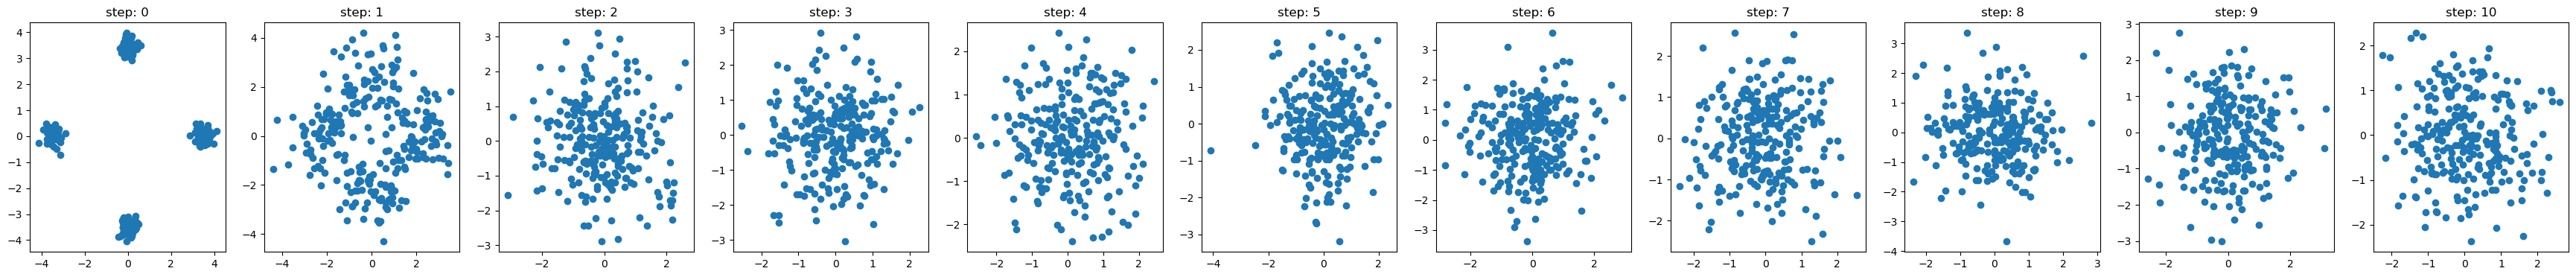

In [ ]:
vp = VPSDE(0.1, 20.0, n_steps=100)
x_0, x_1 = next(sample_batch(256, spread=3.5, sigma=0.2))

trajectory = [x_0]
for t in range(vp.n_steps // 10 - 1, vp.n_steps, vp.n_steps // 10):
    t = torch.ones(256) * t / vp.n_steps
    x_t = vp.sample_x_t_from_x_0(x_0, t)
    trajectory.append(x_t)

plot_trajectory(trajectory)

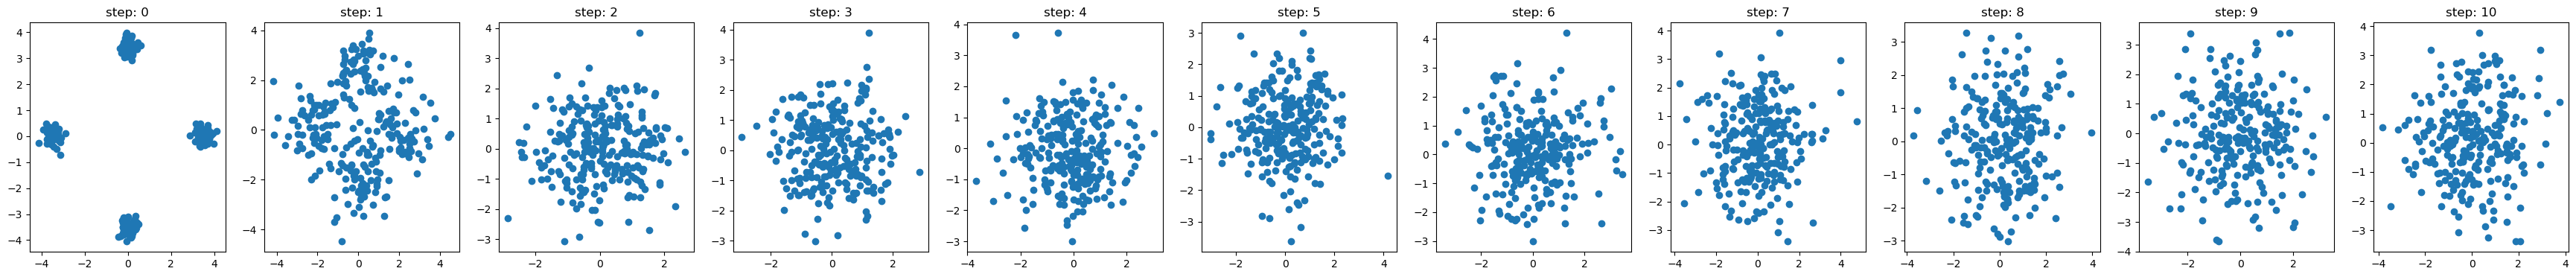

In [ ]:
x_t = x_0.clone()

trajectory = [x_0]
for i in range(vp.n_steps):
    t = torch.ones(256) * i / vp.n_steps
    x_t = x_t + vp.make_fwd_step(x_t, t)
    
    if (i + 1) % (vp.n_steps // 10) == 0:
        trajectory.append(x_t)

plot_trajectory(trajectory)

#### train

In [ ]:
B_SIZE = 256
N_STEPS = 5_000

vp = VPSDE(0.1, 20.0, n_steps=100)
score_model = SimpleNet(64, 64)
optim = torch.optim.AdamW(score_model.parameters(), lr=1e-3)

loss_history = []
for step in trange(N_STEPS):
    optim.zero_grad(set_to_none=True)
    
    x_0, _ = next(sample_batch(256))
    t = torch.rand(x_0.size(0))
    
    loss = vp.compute_loss(score_model, x_0, t, learn_score=False)
    
    loss.backward()
    optim.step()
    
    loss_history.append(loss.item())

  0%|          | 0/5000 [00:00<?, ?it/s]

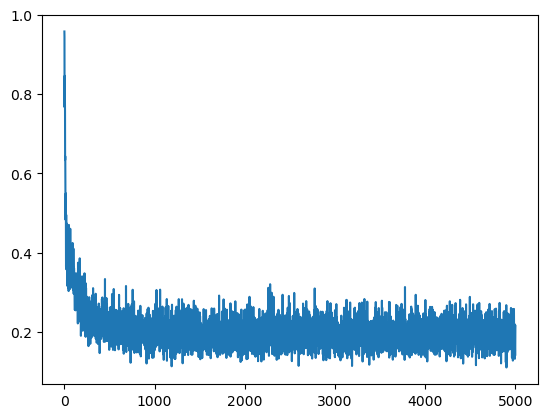

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
vp = VPSDE(0.1, 20.0, n_steps=100)
x_t = torch.randn(256, 2)
trajectory = [x_t]

for t in range(vp.n_steps - 1, -1, -1):
    t = torch.maximum(torch.ones(256) * t, torch.as_tensor(1e-3)) / vp.n_steps
    score = vp.score_from_noise(score_model, x_t, t)
    x_t = x_t + vp.make_bwd_step(score, x_t, t, ode_flow=False)
    
    trajectory.append(x_t)


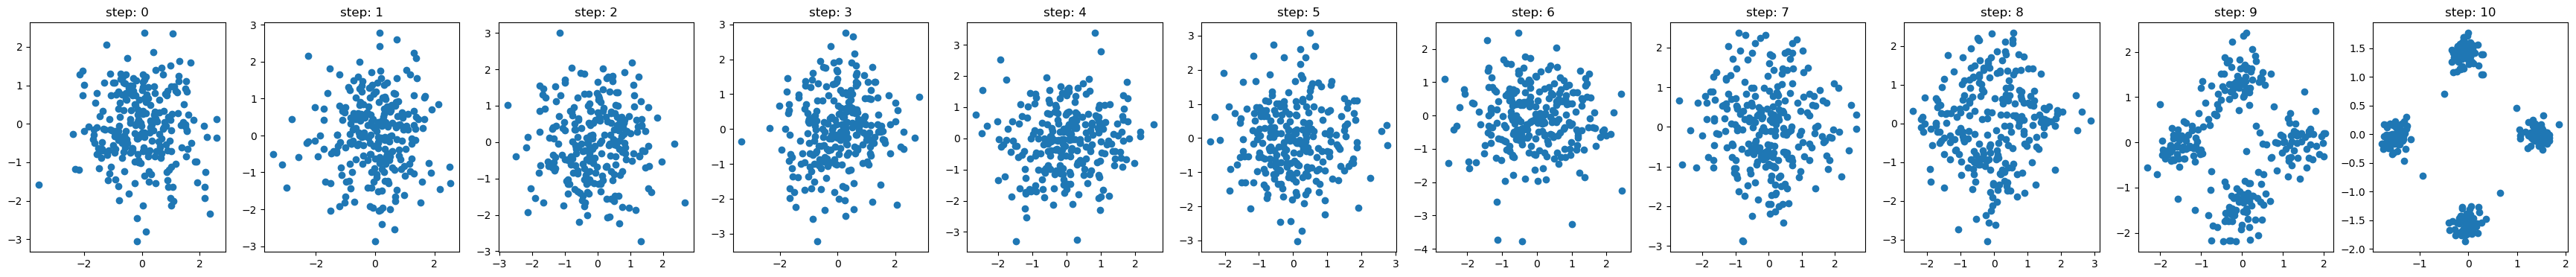

In [ ]:
plot_trajectory([trajectory[i] for i in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 - 1]])
# plot_trajectory(trajectory)

# VESDE & SMLD

In [ ]:
class VESDE:
    t_max = 1.0
    
    def __init__(self, beta_min, beta_max, n_steps):
        self.beta_min = beta_min #* 1000 / n_steps
        self.beta_max = beta_max #* 1000 / n_steps
        self.n_steps = n_steps

    def get_beta_t(self, t):
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def get_mean_coeff_and_std(self, t):
        log_coeff = - 0.25 * t**2 * (self.beta_max - self.beta_min) - 0.5 * t * self.beta_min
        mean = torch.exp(log_coeff)
        std = torch.sqrt(1 - torch.exp(2.0 * log_coeff))
        return mean, std

    def sample_x_t_from_x_0(self, x_0, t, noise: Tensor | None = None):
        if noise is None:
            noise = torch.randn_like(x_0)
        
        mean, std = self.get_mean_coeff_and_std(t)
        return extract_into_tensor(mean, x_0.shape) * x_0 + noise * extract_into_tensor(std, x_0.shape)

    def get_sde_params(self, x_t, t):
        '''
            Compute coefficient for SDE:
            dx_t = f_t * dt + g_t * dW_t
        '''
        beta_t = extract_into_tensor(self.get_beta_t(t), x_t.shape)
        drift = - 0.5 * beta_t * x_t
        
        return drift, beta_t.sqrt()
    
    def get_reverse_sde_params(self, score, x_t, t, ode_flow: bool = False):
        drift, diff = self.get_sde_params(x_t, t)
        rev_drift = drift - diff**2 * score * (0.5 if ode_flow else 1.0)
        
        return rev_drift, diff

    def compute_loss(self, model, x_0, t, learn_score: bool = True):
        noise = torch.randn_like(x_0)
        
        time = torch.maximum(t, torch.as_tensor(1e-3))
        x_t = self.sample_x_t_from_x_0(x_0, time, noise)
        
        if learn_score:
            mean_coeff, std = self.get_mean_coeff_and_std(time)
            mean_coeff = extract_into_tensor(mean_coeff, x_0.shape)
            std = extract_into_tensor(std, x_0.shape)
            
            score = - (x_t - mean_coeff * x_0) / std**2
            loss = nn.functional.mse_loss(model(x_t, t), score)
        else:
            loss = nn.functional.mse_loss(model(x_t, t), noise)

        return loss

    def score_from_noise(self, model, x_t, t):
        eps_pred = model(x_t, t)
        _, std = self.get_mean_coeff_and_std(t)
        return - eps_pred / extract_into_tensor(std, eps_pred.shape)

    def make_fwd_step(self, x_t, t, dt: float | None = None):
        '''
            Noise for forward process.
        '''
        z = torch.randn_like(x_t)
        drift, sigma = self.get_sde_params(x_t, t)
        if dt is None:
            dt = self.t_max / self.n_steps
        
        return drift * dt + sigma * math.sqrt(dt) * z

    @torch.no_grad
    def make_bwd_step(self, score, x_t, t, dt: float | None = None, ode_flow: bool = False):
        '''
            Denoising backward process.
        '''
        z = torch.randn_like(x_t)
        drift, diff = self.get_reverse_sde_params(score, x_t, t, ode_flow)
        if dt is None:
            dt = - self.t_max / self.n_steps
        
        dx = drift * dt
        if not ode_flow:
            dx = dx + diff * math.sqrt(-dt) * z
        
        return dx

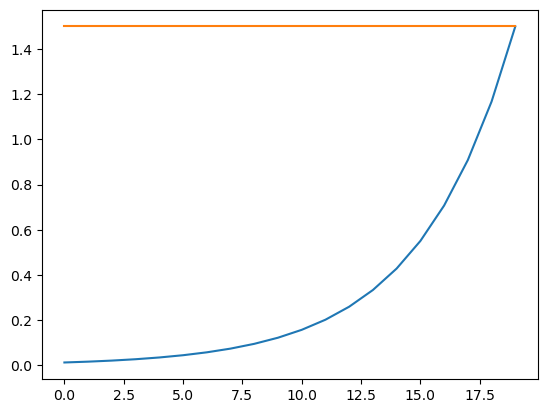

In [ ]:
sigma_min = 0.01
sigma_max = 1.5
n_steps = 20

step = (sigma_max / sigma_min) ** (1 / n_steps)
sigma_schedule = [sigma_min * step**(i+1) for i in range(n_steps)]
plt.plot(sigma_schedule)
plt.plot([sigma_max] * n_steps)
plt.show()

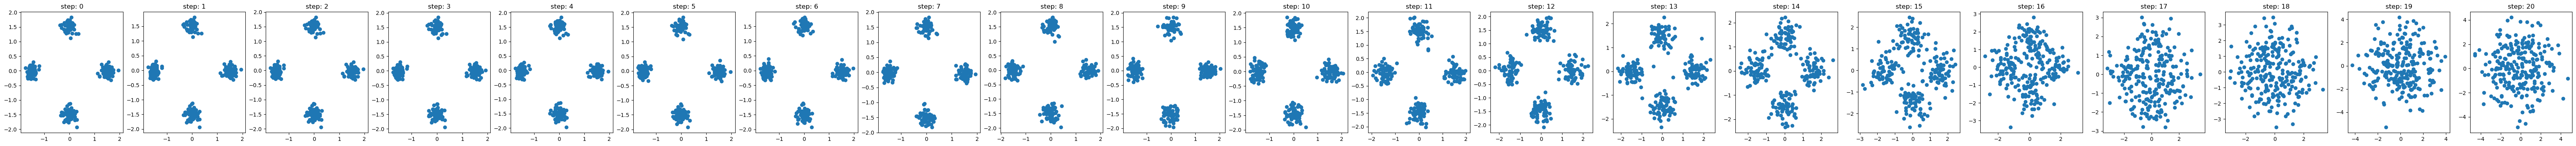

In [ ]:
x_0, _ = next(sample_batch(256))

trajectory = [x_0]
for sigma in sigma_schedule:
    trajectory.append(x_0 + torch.randn_like(x_0) * sigma)

plot_trajectory(trajectory)

In [ ]:
sigma_min = 0.01
sigma_max = 1.5
n_steps = 20

sigma_coeff = (sigma_max / sigma_min) ** (1 / n_steps) 

In [ ]:
score = SimpleNet(64, 64)
optim = torch.optim.AdamW(score.parameters(), lr=1e-3)

loss_history = []
for step in trange(N_STEPS):
    optim.zero_grad(set_to_none=True)
    
    x_0, _ = next(sample_batch(256))
    steps = torch.randint(1, n_steps + 1, (x_0.size(0),))
    sigma = extract_into_tensor(sigma_min * (sigma_coeff) ** (steps), x_0.shape)
    
    x_sigma = x_0 + sigma * torch.randn_like(x_0)
    pred_score = score(x_sigma, sigma.squeeze(-1))
    true_score = - (x_sigma - x_0) / sigma**2
    loss = nn.functional.mse_loss(pred_score, true_score)
    
    loss.backward()
    optim.step()
    
    loss_history.append(loss.item())

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
x = torch.randn(256, 2)
eps = 0.1

curr_sigma = sigma_max

for i in range(n_steps, 0, -1):
    curr_score = score(x, sigma)
    x = 
    
    sigma = sigma_min / (sigma_coeff**i) * torch.ones(x.size(0))
    
    

# Sliced SM

In [ ]:
def sliced_score_matching_loss(score_model, x):
    
    v, 
    
    grad = torch.autograd.grad((score_model(x) * v).sum(), x_0, retain_graph=True)[0]
    score = score_model(x)
    loss_hte = (grad * v_t).sum()
    loss_score_norm = score.sum().pow(2) / 2
    loss = loss_hte + loss_score_norm
    return loss, loss_hte, loss_score_norm

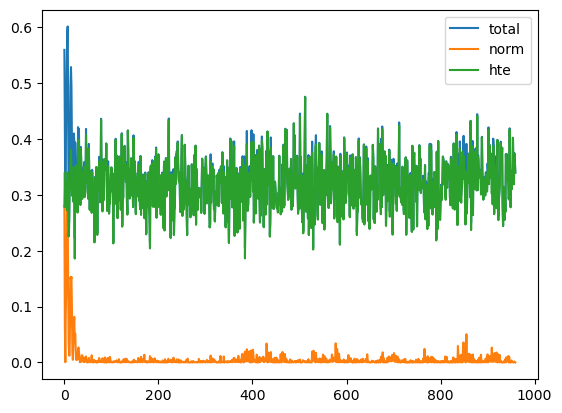

In [ ]:
plt.plot(loss_history[40:], label='total')
plt.plot(norm_history[40:], label='norm')
plt.plot(hte_history[40:], label='hte')
plt.legend()
plt.show()

# SB via IPF

In [ ]:
@torch.no_grad()
def make_ref_process_step(x, t, gamma, F = None, var=2.0, t_max=0.2):        
    z = torch.randn_like(x)

    mask = ((t != gamma) * (t != t_max - gamma))
    # mean, var = F(x, t)

    return F(x, t) + mask.view(-1, 1) * math.sqrt(var * gamma) * z

In [91]:
alpha = 0.16
gamma = 0.01
t_max = 0.2
n_steps = 20

In [92]:
class EMALoss:
    def __init__(self, alpha=0.1):
        self.ema = []
        self.loss = []
        self.alpha = alpha

    def update(self, loss_value):
        self.loss.append(loss_value)
        if not self.ema:
            self.ema.append(loss_value)
        else:
            self.ema.append(loss_value * self.alpha + self.ema[-1] * (1 - self.alpha))


class VarCriterion:
    def __init__(self, loss, threshold=0.001, measure_size: int = 10, max_iter=1000):
        self.loss = loss
        self.threshold = threshold
        self.measure_size = measure_size
        
        self.max_iter = max_iter
        self.curr_iter = 0

    def check(self):
        self.curr_iter += 1
        
        if self.curr_iter > self.max_iter:
            return False
        
        if len(self.loss) < self.measure_size:
            return True
        
        return np.var(self.loss[-self.measure_size:]) > self.threshold


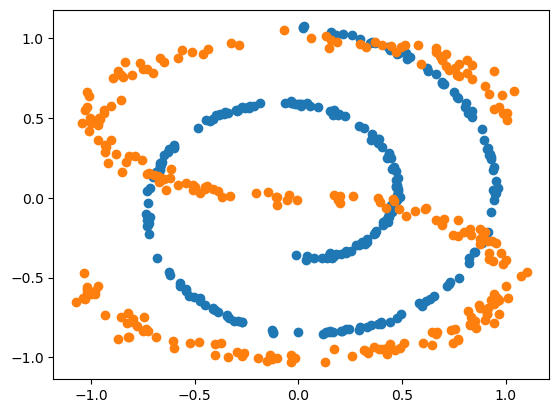

In [93]:
mean = torch.tensor([[-1, 1], [1, 1], [1, -1], [-1, -1]]) * 1.0
sigma = torch.ones_like(mean) * 0.1

sampler = DatasetSampler(
    # p_0='mix_of_gaussians', p_0_args=[mean, sigmas],
    p_0='swiss_roll', p_0_args=[None, 0.1],
    p_1='s_curve', p_1_args=[None, 0.05],
)
x_0, x_1 = sampler.sample(256)
scatter(x_0)
scatter(x_1)
plt.show()

#### Training B via score and mean matching

In [99]:
alpha = 0.16
gamma = 0.01
t_max = 0.2
n_steps = 20
# n_steps = int(t_max / gamma)

In [ ]:
def compute_b_model_loss(model, reference, x_t, t, mean: bool = True):
    with torch.no_grad():
        x_t_m_gamma = make_ref_process_step(x_t, t, gamma, F=reference)
        target = x_t if mean else (x_t_m_gamma + reference(x_t, t) - reference(x_t_m_gamma, t))
    
    prediction = model(x_t_m_gamma, t - gamma) #+ (torch.randn_like(x_t) * math.sqrt(2 * gamma) if mean else 0)
    prediction = prediction + torch.randn_like(x_t) * math.sqrt(2 * gamma)
    return nn.functional.mse_loss(prediction, target), x_t_m_gamma

In [101]:
N_MAX_ITER = 3000
USE_MEAN_MATCHING = True

B_model = SimpleNet(64, 64)
ref_process = lambda x, t: x - gamma * alpha * x
optim_B = torch.optim.Adam(B_model.parameters(), lr=1e-3)

ema_loss = EMALoss()
var_crit = VarCriterion(ema_loss.ema, threshold=2e-9, max_iter=N_MAX_ITER, measure_size=500)

with tqdm(total=N_MAX_ITER, leave=False) as pbar:

    while var_crit.check():
        traj_loss = 0
        optim_B.zero_grad(set_to_none=True)
        
        _, x_t = sampler.sample(256)
        for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
            t = torch.ones(256) * t_step
                        
            loss, _ = compute_b_model_loss(B_model, ref_process, x_t, t, mean=USE_MEAN_MATCHING)   
            
            loss.backward()
            traj_loss += loss.item()

        ema_loss.update(traj_loss / n_steps)
        optim_B.step()
        
        pbar.update(1)

pbar.close()

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

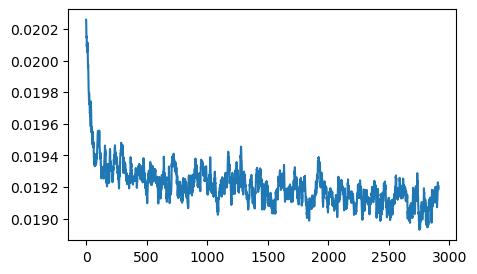

In [84]:
plt.figure(figsize=(5, 3))
plt.plot(ema_loss.ema[90:])
plt.show()

Reference process


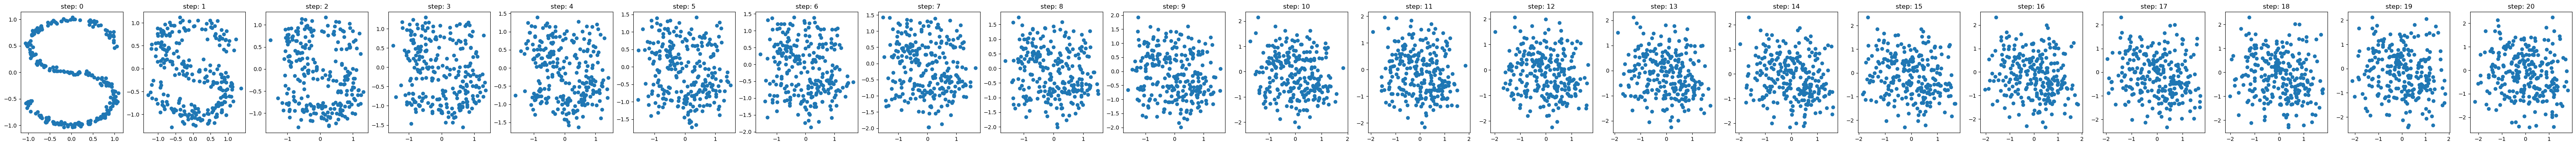

Learned trajectory for B


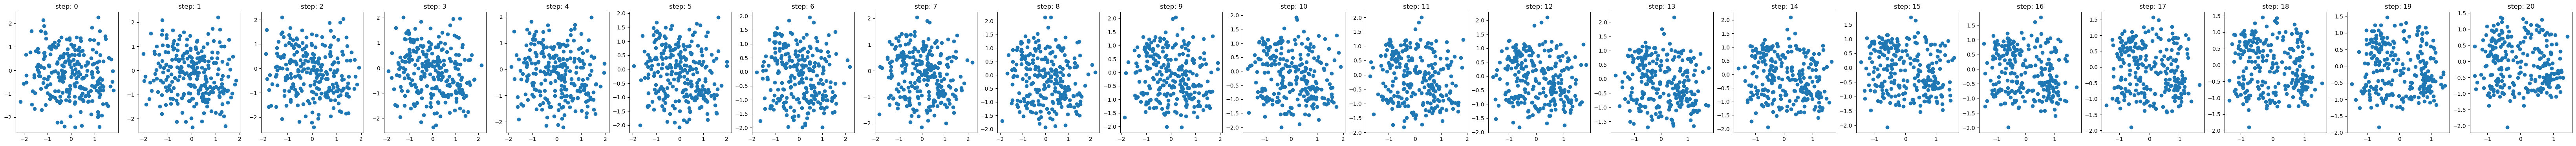

In [85]:
_, x_1 = sampler.sample(256)
B_reference = lambda x, t: x - gamma * alpha * x

reference_trajectory = [x_1]
for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
    t = torch.ones(256) * t_step
    x_next = make_ref_process_step(reference_trajectory[-1], t, gamma, F=B_reference)
    reference_trajectory.append(x_next)

print('Reference process')
plot_trajectory(reference_trajectory)


learned_trajectory = [reference_trajectory[-1]]
with torch.no_grad():
    for t_step in torch.linspace(0, t_max - gamma, n_steps):
        t = torch.ones(256) * t_step
        x_next = make_ref_process_step(learned_trajectory[-1], t, gamma, F=B_model)
        learned_trajectory.append(x_next)

print('Learned trajectory for B')
f = plot_trajectory(learned_trajectory)

#### Training F via score and mean matching

In [108]:
def compute_f_model_loss(model, reference, x_t, t, mean: bool = True):
    with torch.no_grad():
        x_t_p_gamma = make_ref_process_step(x_t, t, gamma, F=reference)
        target = x_t if mean else (x_t_p_gamma + reference(x_t, t) - reference(x_t_p_gamma, t))
    
    prediction = model(x_t_p_gamma, t + gamma) #+ (math.sqrt(2 * gamma) * torch.randn_like(x_t) if mean else 0)
    
    return nn.functional.mse_loss(prediction, target), x_t_p_gamma

In [86]:
N_MAX_ITER = 3000
USE_MEAN_MATCHING = True

F_model = SimpleNet(64, 64)
ref_process = lambda x, t: x - gamma * alpha * x
optim_F = torch.optim.Adam(F_model.parameters(), lr=1e-3)

ema_loss = EMALoss()
var_crit = VarCriterion(ema_loss.ema, threshold=5e-9, max_iter=N_MAX_ITER, measure_size=500)

while var_crit.check():
    traj_loss = 0
    optim_F.zero_grad(set_to_none=True)

    x_t, _ = next(sample_batch(256, spread=3.5, sigma=0.2))
    for t_step in torch.linspace(0, t_max - gamma, n_steps):
        t = torch.ones(256) * t_step

        loss, x_t = compute_f_model_loss(F_model, ref_process, x_t, t, mean=USE_MEAN_MATCHING)
    
        loss.backward()
        traj_loss += loss.item()

    ema_loss.update(traj_loss / n_steps)
    optim_F.step()

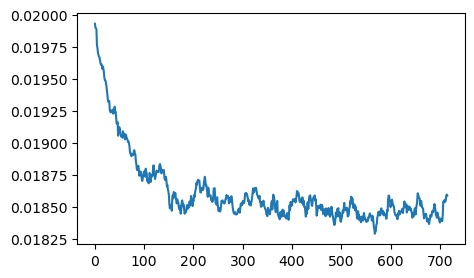

In [87]:
plt.figure(figsize=(5, 3))
plt.plot(ema_loss.ema[160:])
plt.show()

Reference Trajectory


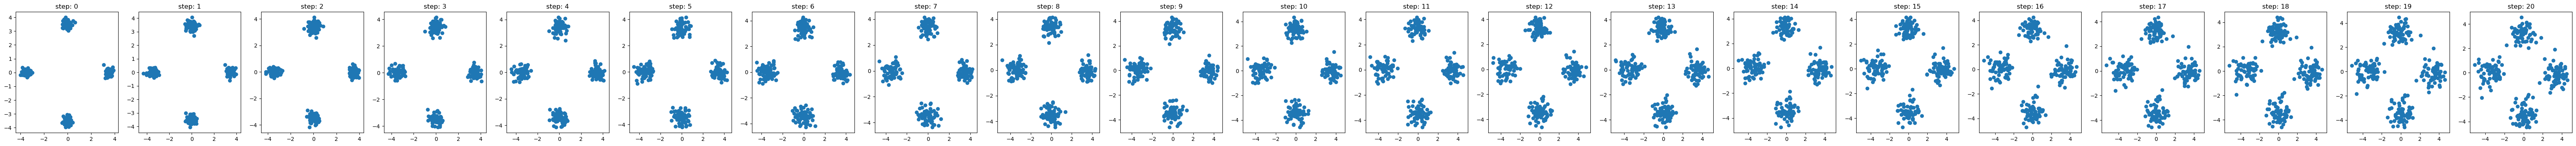

Learned Trajectory for F


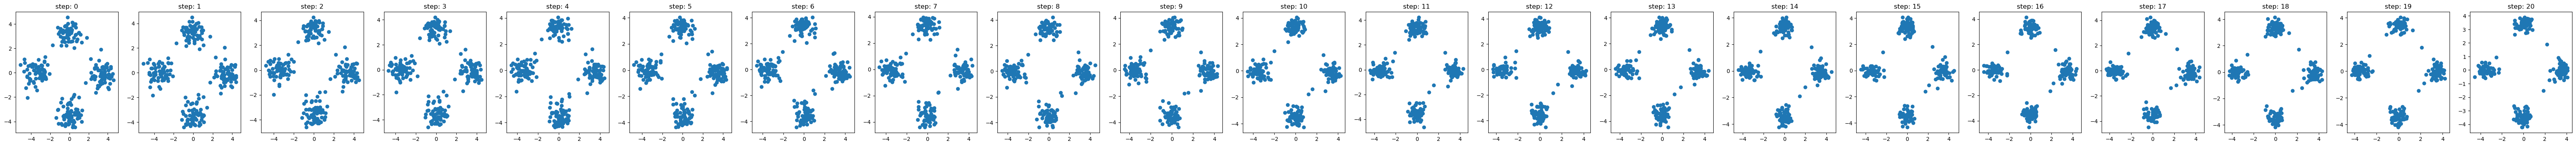

In [88]:
x_0, _ = next(sample_batch(256, spread=3.5, sigma=0.2))
ref_process = lambda x, t: x - gamma * alpha * x

ref_trajectory = [x_0]
for t_step in torch.linspace(0, t_max - gamma, n_steps):
    t = torch.ones(256) * t_step
    x_next = make_ref_process_step(ref_trajectory[-1], t, gamma, F=ref_process)
    ref_trajectory.append(x_next)

print('Reference Trajectory')
plot_trajectory(ref_trajectory)

learned_trajectory = [ref_trajectory[-1]]
with torch.no_grad():
    for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
        t = torch.ones(256) * t_step
        x_next = make_ref_process_step(learned_trajectory[-1], t, gamma, F=F_model)
        learned_trajectory.append(x_next)

print('Learned Trajectory for F')
plot_trajectory(learned_trajectory)

#### Full SBM

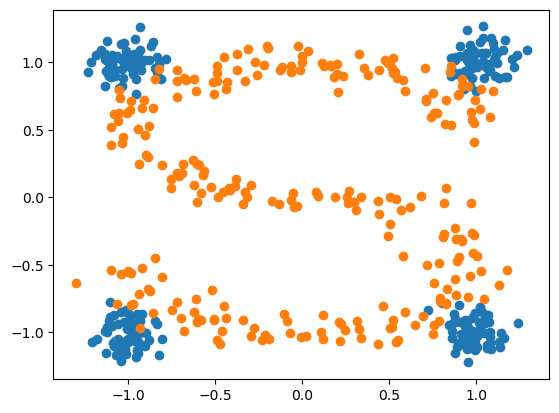

In [145]:
mean = torch.tensor([[-1, 1], [1, 1], [1, -1], [-1, -1]]) * 1.0
sigma = torch.ones_like(mean) * 0.1

sampler = DatasetSampler(
    # p_0='mix_of_gaussians', p_0_args=[mean, sigmas],
    p_0='mix_of_gaussians', p_0_args=[mean, sigma],
    p_1='s_curve', p_1_args=[None, 0.15],
)
x_0, x_1 = sampler.sample(256)
scatter(x_0)
scatter(x_1)
plt.show()

In [120]:
alpha = 0.16
NUM_STEPS = 20
MAX_CONVERGENCE_ITER = 3000

reference = lambda x, t: x - gamma * alpha * x
B_model = SimpleNet(64, 64)
F_model = SimpleNet(64, 64)

optim_B = torch.optim.Adam(B_model.parameters(), lr=3e-4)
optim_F = torch.optim.Adam(F_model.parameters(), lr=3e-4)

In [121]:
for i in trange(NUM_STEPS):
    ema_loss = EMALoss()
    var_crit = VarCriterion(ema_loss.ema, threshold=1e-8, max_iter=MAX_CONVERGENCE_ITER, measure_size=500)

    with tqdm(leave=False, desc=f'step {i + 1}, training B model') as pbar:
        while var_crit.check():
            traj_loss = 0
            optim_B.zero_grad(set_to_none=True)
            
            _, x_t = sampler.sample(256)
            for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
                t = torch.ones(256) * t_step
                loss, x_t = compute_b_model_loss(B_model, reference if i == 0 else F_model, x_t, t, mean=True)   
                
                loss.backward()
                traj_loss += loss.item()

            ema_loss.update(traj_loss / n_steps)
            optim_B.step()
            
            pbar.update(1)
        pbar.close()

    ema_loss = EMALoss()
    var_crit = VarCriterion(ema_loss.ema, threshold=1e-8, max_iter=MAX_CONVERGENCE_ITER, measure_size=500)

    with tqdm(leave=False, desc=f'step {i + 1}, training F model') as pbar:
        while var_crit.check():
            traj_loss = 0
            optim_F.zero_grad(set_to_none=True)

            x_t, _ = sampler.sample(256)
            for t_step in torch.linspace(0, t_max - gamma, n_steps):
                t = torch.ones(256) * t_step
                loss, x_t = compute_f_model_loss(F_model, B_model, x_t, t, mean=True)
            
                loss.backward()
                traj_loss += loss.item()

            ema_loss.update(traj_loss / n_steps)
            optim_F.step()

            pbar.update(1)
        pbar.close()

  0%|          | 0/20 [00:00<?, ?it/s]

step 1, training B model: 0it [00:00, ?it/s]

step 1, training F model: 0it [00:00, ?it/s]

step 2, training B model: 0it [00:00, ?it/s]

step 2, training F model: 0it [00:00, ?it/s]

step 3, training B model: 0it [00:00, ?it/s]

step 3, training F model: 0it [00:00, ?it/s]

step 4, training B model: 0it [00:00, ?it/s]

step 4, training F model: 0it [00:00, ?it/s]

step 5, training B model: 0it [00:00, ?it/s]

step 5, training F model: 0it [00:00, ?it/s]

step 6, training B model: 0it [00:00, ?it/s]

step 6, training F model: 0it [00:00, ?it/s]

step 7, training B model: 0it [00:00, ?it/s]

step 7, training F model: 0it [00:00, ?it/s]

step 8, training B model: 0it [00:00, ?it/s]

step 8, training F model: 0it [00:00, ?it/s]

step 9, training B model: 0it [00:00, ?it/s]

step 9, training F model: 0it [00:00, ?it/s]

step 10, training B model: 0it [00:00, ?it/s]

step 10, training F model: 0it [00:00, ?it/s]

step 11, training B model: 0it [00:00, ?it/s]

step 11, training F model: 0it [00:00, ?it/s]

step 12, training B model: 0it [00:00, ?it/s]

step 12, training F model: 0it [00:00, ?it/s]

step 13, training B model: 0it [00:00, ?it/s]

step 13, training F model: 0it [00:00, ?it/s]

step 14, training B model: 0it [00:00, ?it/s]

step 14, training F model: 0it [00:00, ?it/s]

step 15, training B model: 0it [00:00, ?it/s]

step 15, training F model: 0it [00:00, ?it/s]

step 16, training B model: 0it [00:00, ?it/s]

step 16, training F model: 0it [00:00, ?it/s]

step 17, training B model: 0it [00:00, ?it/s]

step 17, training F model: 0it [00:00, ?it/s]

step 18, training B model: 0it [00:00, ?it/s]

step 18, training F model: 0it [00:00, ?it/s]

step 19, training B model: 0it [00:00, ?it/s]

step 19, training F model: 0it [00:00, ?it/s]

step 20, training B model: 0it [00:00, ?it/s]

step 20, training F model: 0it [00:00, ?it/s]

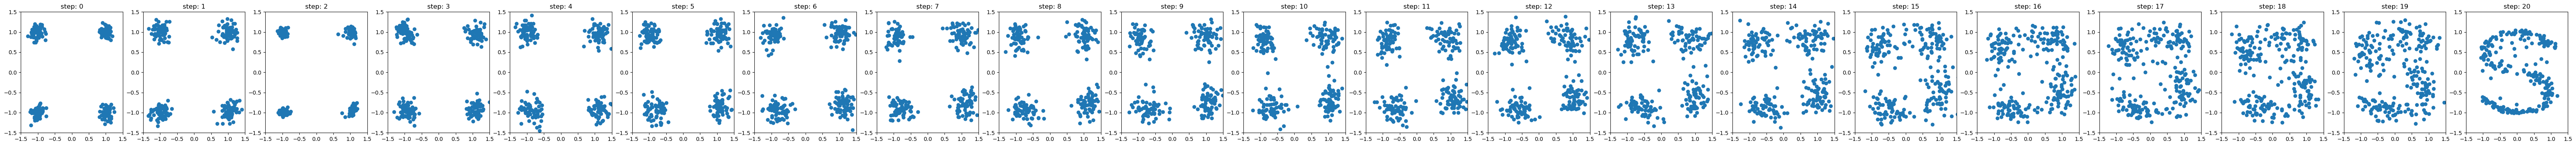

In [147]:
x_0, x_1 = sampler.sample(256)

trajectory = [x_0]

with torch.no_grad():
    for t_step in torch.linspace(0, t_max - gamma, n_steps):
        t = torch.ones(256) * t_step
        x_next = make_ref_process_step(trajectory[-1], t, gamma, F=B_model)
        trajectory.append(x_next)

fig = plot_trajectory(trajectory)

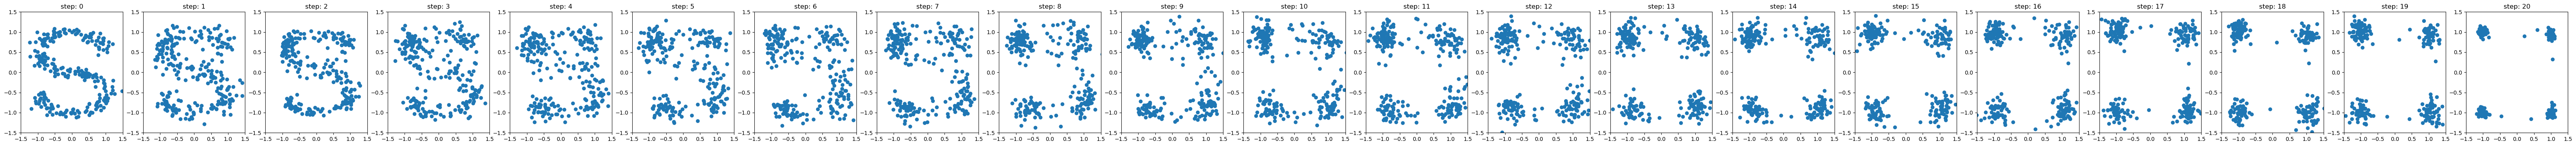

In [148]:
x_0, x_1 = sampler.sample(256)

trajectory = [x_1]

with torch.no_grad():
    for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
        t = torch.ones(256) * t_step
        x_next = make_ref_process_step(trajectory[-1], t, gamma, F=F_model)
        trajectory.append(x_next)

fig = plot_trajectory(trajectory)

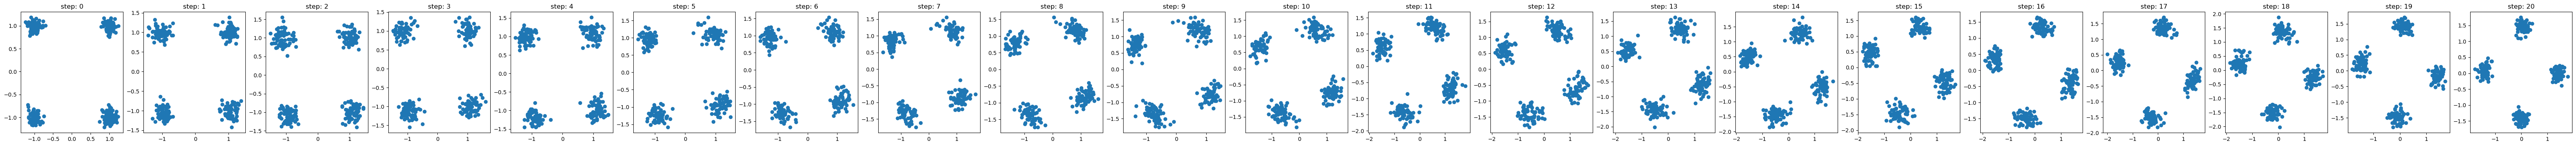

In [114]:
x_0, x_1 = sampler.sample(256)

trajectory = [x_0]

with torch.no_grad():
    for t_step in torch.linspace(0, t_max - gamma, n_steps):
        t = torch.ones(256) * t_step
        x_next = make_ref_process_step(trajectory[-1], t, gamma, F=B_model)
        trajectory.append(x_next)

fig = plot_trajectory(trajectory)

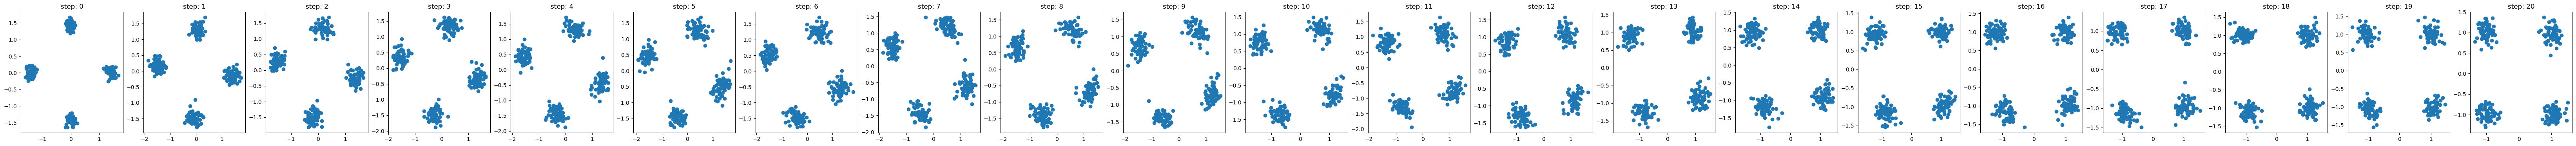

In [115]:
x_0, x_1 = sampler.sample(256)

trajectory = [x_1]

with torch.no_grad():
    for t_step in torch.linspace(gamma, t_max, n_steps).flip(-1):
        t = torch.ones(256) * t_step
        x_next = make_ref_process_step(trajectory[-1], t, gamma, F=F_model)
        trajectory.append(x_next)

fig = plot_trajectory(trajectory)